Import libraries, model load

In [148]:
import keras
import imutils
import cv2
import os
from imutils import paths
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from itertools import product
import tensorflow as tf

num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(8, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model = keras.models.load_model("./Train data/Classifier.keras")

Load local data path

In [51]:
folder_path = './Dataset/heatmap'
input_folder = '/input/'
output_folder = '/splitted/'
heatmap_folder = '/heatmap/'

Processing data, split to 256 x 256

In [36]:
dr_images = os.listdir(folder_path + input_folder)

output_size = 256

image_size_width = 14619
image_size_height = 10438

def tile(filename, dir_in, dir_out, output_size):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    image_size_width = w
    image_size_height = h
    
    grid = product(range(0, h-h%output_size, output_size), range(0, w-w%output_size, output_size))
    for i, j in grid:
        box = (j, i, j+output_size, i+output_size)
        out = os.path.join(dir_out, f'S{name}_{i}_{j}{ext}')
        image = cv2.imread(out)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=Image.fromarray(image)
        image = np.array(image)
        dataset=[]
        dataset.append(image)
        dataset = np.reshape(dataset, (len(dataset), output_size, output_size, 3))
        decoded_imgs = model.predict(dataset[0:1], batch_size=32)
        print(decoded_imgs[0])

        break
        
for image_name in dr_images:
	tile(image_name, folder_path + input_folder, folder_path + output_folder, output_size)

1/1 [==============================] - 0s 31ms/step
[-40.03846   34.01523    9.344778]


Import presaved model

In [147]:
# input layer
input_layer = Input(shape=(output_size,output_size,3))

# encoder
encoded_layer1 = Conv2D(filters = 256,  kernel_size = (4, 4), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded = Conv2D(filters = 1, kernel_size = (2, 2), activation='relu', padding='same')(encoded_layer2)                                                             
decoded_layer1 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(filters = 256,  kernel_size = (4, 4), activation='relu', padding='same')(decoded_layer1)
output_layer   = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(decoded_layer2)

# compile the model
encoder = Model(input_layer, encoded)
decoder = Model(encoded,output_layer)
compression_model = Model(input_layer, decoder(encoder(input_layer)))
compression_model.compile(optimizer='adam', loss='mse')

# load weights
compression_model = keras.models.load_model("Train data/256_m_weights.keras")
encoder = keras.models.load_model("Train data/256_e_weights.keras")
decoder = keras.models.load_model("Train data/256_d_weights.keras")

Metrics

In [ ]:
import gzip
class_names = ['EMPTY', 'HARD', 'LINEAR']

dr_images = os.listdir(folder_path + input_folder)
heatmap_np = np.zeros((40,57))
heatmap_i = 0
heatmap_j = 0

def tile(filename, dir_in, dir_out, output_size):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = product(range(0, h-h%output_size, output_size), range(0, w-w%output_size, output_size))
    for i, j in grid:
        box = (j, i, j+output_size, i+output_size)
        out = os.path.join(dir_out, f'S{name}_{i}_{j}{ext}')
        heatmap_i = i//256
        heatmap_j = j//256
        image = cv2.imread(out)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=Image.fromarray(image)
        image = np.array(image)
        dataset=[]
        dataset.append(image)
        dataset = np.reshape(dataset, (len(dataset), output_size, output_size, 3))
        decoded_imgs = model.predict(dataset[0:1], batch_size=32)
        print(decoded_imgs[0])
        image = np.array(image)/255
        dataset=[]
        dataset.append(image)
        dataset = np.reshape(dataset, (len(dataset), output_size, output_size, 3))
        
        heatmap_np[heatmap_i, heatmap_j] = np.argmax(decoded_imgs)
        if (heatmap_np[heatmap_i, heatmap_j] >= 0 ):
          image = compression_model.predict(dataset[0:1], batch_size=32)
          image = image * 256
          image = image.astype('int16')

          f = gzip.GzipFile(folder_path + "/compressed/" + f'S{name}_{i}_{j}{ext}', "w")
          np.save(file=f, arr=image)

        
for image_name in dr_images:
	tile(image_name, folder_path + input_folder, folder_path + output_folder, output_size)

Heatmap visualization

In [ ]:
class_names = ['EMPTY', 'HARD', 'LINEAR']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 100]) 
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

dr_images = os.listdir(folder_path + input_folder)

output_size = 256

image_size_width = 14619
image_size_height = 10438


heatmap_np = np.zeros((40,57))
heatmap_i = 0
heatmap_j = 0


def tile(filename, dir_in, dir_out, output_size):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = product(range(0, h-h%output_size, output_size), range(0, w-w%output_size, output_size))
    for i, j in grid:
        box = (j, i, j+output_size, i+output_size)
        out = os.path.join(dir_out, f'S{name}_{i}_{j}{ext}')
        heatmap_i = i//256
        heatmap_j = j//256       
        image = cv2.imread(out)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=Image.fromarray(image)
        image = np.array(image)#/255
        dataset=[]
        dataset.append(image)
        dataset = np.reshape(dataset, (len(dataset), output_size, output_size, 3))
        decoded_imgs = model.predict(dataset[0:1], batch_size=32)
        print(decoded_imgs[0])
        
        heatmap_np[heatmap_i, heatmap_j] = np.argmax(decoded_imgs)
        if (heatmap_np[heatmap_i, heatmap_j] == 1):
           heatmap_np[heatmap_i, heatmap_j] = 2
        elif (heatmap_np[heatmap_i, heatmap_j] == 2):
           heatmap_np[heatmap_i, heatmap_j] = 1      
        
for image_name in dr_images:
	tile(image_name, folder_path + input_folder, folder_path + output_folder, output_size)


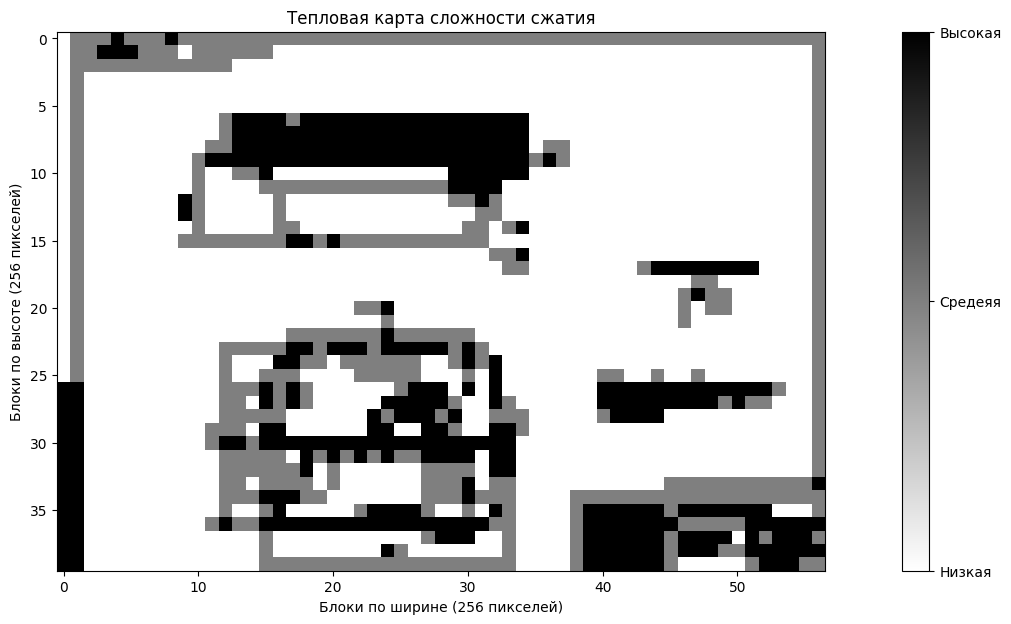

In [144]:
import matplotlib.colors as colors
plt.figure(figsize=(20,7))
colors_list = ['#0099ff', '#33cc33','#33cc33']
cmap = colors.ListedColormap(colors_list) 

plt.imshow(heatmap_np, cmap='binary', interpolation='nearest')

cbar = plt.colorbar(ticks=[0, 1, 2])

cbar.ax.set_yticklabels(['Низкая', 'Средеяя', 'Высокая']) 

plt.title("Тепловая карта сложности сжатия") 
plt.xlabel("Блоки по ширине (256 пикселей)") 
plt.ylabel("Блоки по высоте (256 пикселей)") 
plt.show()